# LinkNet: нейронная сеть для семантической сегментации изображений

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

По архитектуре LinkNet похож на стандартный автоэнкодер: каждый encoder (decoder) блок уменьшает (увеличивает) размерность карт признаков в два раза, в то время как количество карт увеличивается (уменьшается) в два раза. Основное отличие от других нейронных сетей, используемых для сегментации изображений, состоит в соединении encoder и decoder блоков напрямую (skip connections). Такой подход позволяет полнее использовать информацию, содержащуюся в исходном изображении, а также позволяет решить проблему обучения глубоких сетей (данная сеть содержит 32 слоя). Между сверточными слоями используются ReLU.

<img src='./pic/01.PNG' width="400" height="300">

<img src='pic/02.PNG' width="1000" height="400">

Воспользуемся LinkNet для сегментации изображений $128 \times 128$, в которых в случайном месте располагается изображение MNIST $28 \times 28$ и добавлен шум.
<img src='pic/03.PNG' width="200" height="200">

In [ ]:
import numpy
import sys
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm_notebook as tqm
from time import time
import math

import matplotlib.pyplot as plt

sys.path.append('..')

from linknet import LinkNetBatch
from dataset import Dataset, DatasetIndex
from plot_functions import plot_example_interactive, plot_examples

%matplotlib inline

In [3]:
IMAGE_SIZE = 128
MNIST_SIZE = 65000
BATCH_SIZE = 500
N_EPOCHS = 10
MAX_ITER = 200

In [4]:
# создадим индекс и датасет для построения пайплайна

ind = DatasetIndex(np.arange(MNIST_SIZE))
mnistset = Dataset(ind, batch_class=LinkNetBatch)
mnistset.cv_split([0.9, 0.1])

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [5]:
prediction = []
test_log = []
train_log = []

In [6]:
# пайплайны для обучения и контроля

ppl = mnistset.train.pipeline()\
        .load()\
        .noise_and_mask()\
        .train(sess)\
        .get_stat(sess, train_log, True)
        
ppl_test = mnistset.test.pipeline()\
            .load()\
            .noise_and_mask()\

In [ ]:
# обучение

start = time()
for i in range(MAX_ITER):
    ppl.next_batch(BATCH_SIZE, n_epochs=None)
    ppl_test.get_stat(sess, test_log, False).next_batch(100, n_epochs=None)
    if (i+1) % 20 == 0:
        print("Iter {}: Train loss: {}, test loss: {}".format(i+1, train_log[-1][0], test_log[-1][0]))
stop = time()
print("Train time: {} min".format((stop-start)/60))

In [8]:
test_loss, test_iou = list(zip(*test_log))
train_loss, train_iou = list(zip(*train_log))
test_iou = list(zip(*test_iou))[0]
train_iou = list(zip(*train_iou))[0]

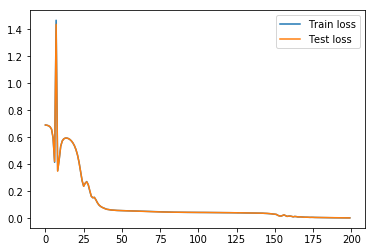

In [9]:
plt1, = plt.plot(train_loss,  label='Train loss')
plt2, = plt.plot(test_loss, label='Test loss')
plt.legend(handles=[plt1, plt2])
plt.show()

In [13]:
prediction = []
ppl_test.predict_proba(sess, prediction).next_batch(10, n_epochs=None)

In [14]:
with open('predictions128.pkl', 'wb') as output:
    pickle.dump(prediction, output, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('predictions128.pkl', 'rb') as inp:
    prediction = pickle.load(inp)

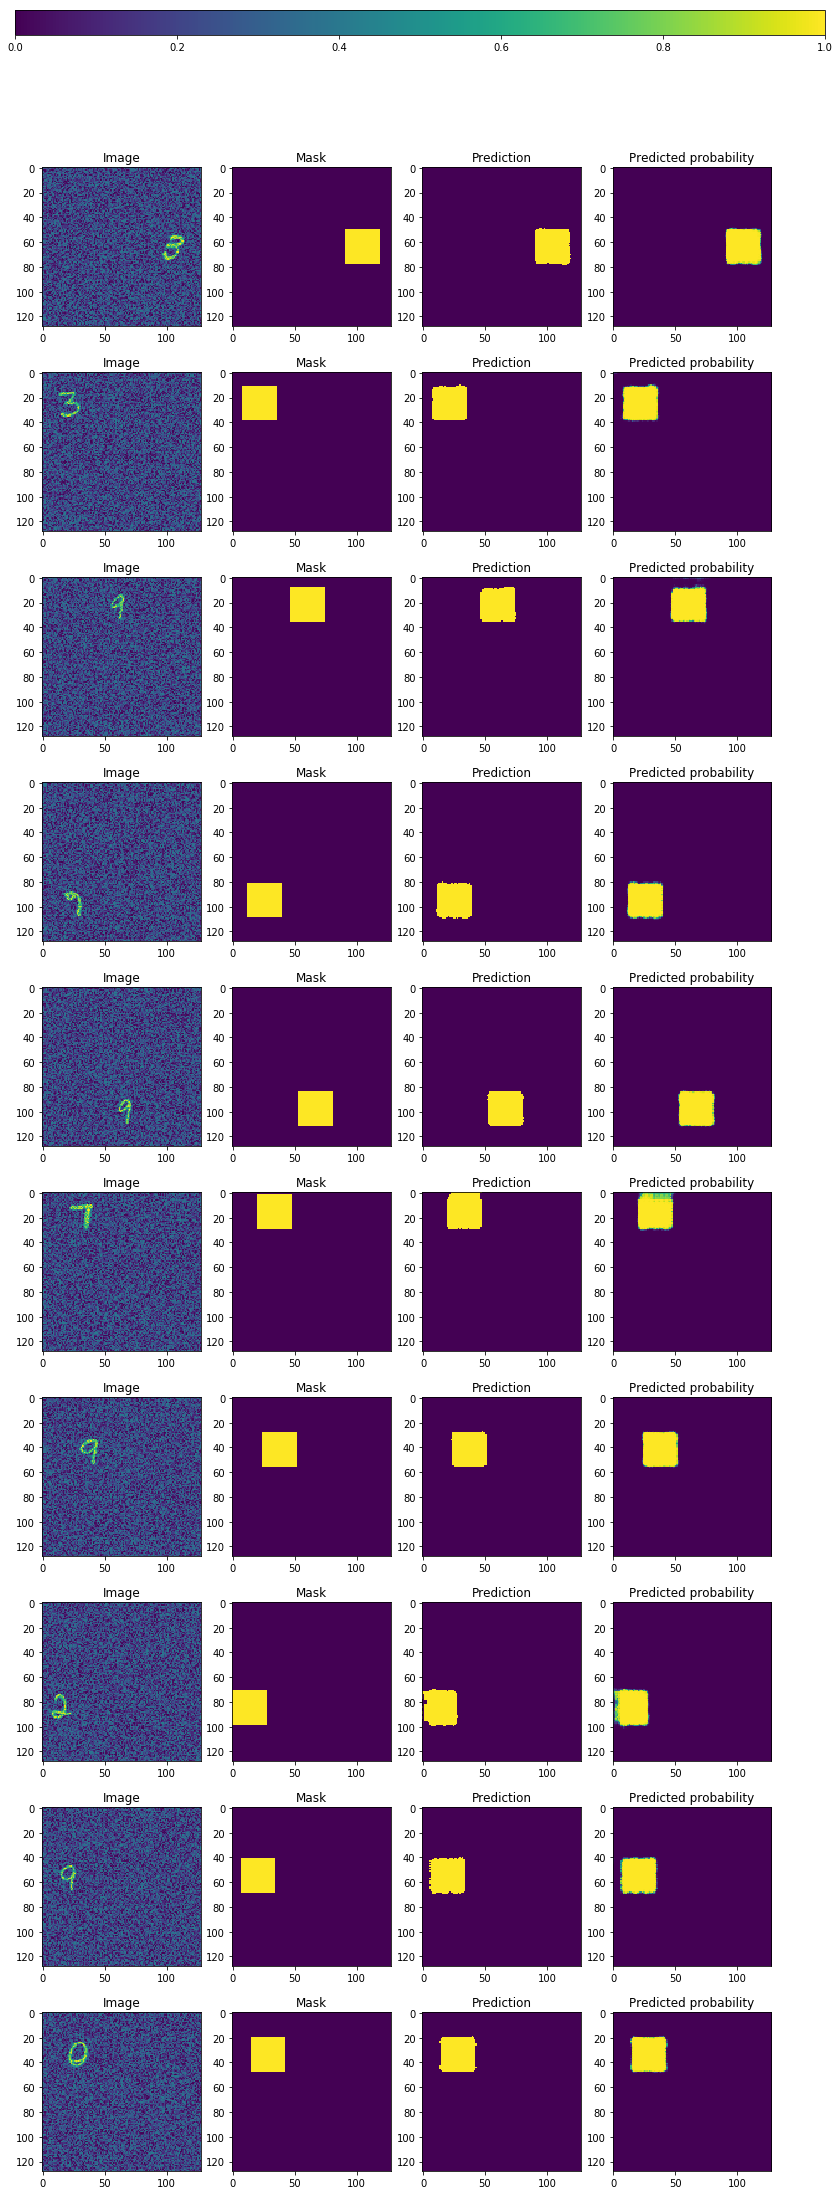

In [6]:
plot_examples(prediction)

In [4]:
plot_example_interactive(prediction, 7)

A Jupyter Widget